### モジュールのインポート

In [2]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import utils as np_utils
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

early_stopping = EarlyStopping(monitor="val_accuracy",
                              min_delta=0.0,
                              patience=5)

### ヒロインたちのリスト & 色

In [3]:
five_sisters = ["Ichika", "Nino", "Miku", "Yotsuba", "Itsuki", "other"] #各ヒロイン名+その他
mem_colors = [(0,255,255), (255,0,204), (255,255,0), (0,255,0), (0,0,255), (255,255,255)] #five_sistersと対応した色

### 学習

In [4]:
#get_cut_face.pyにて切り出したグレースケール顔画像を取得
def get_dataset():
    X, y = [], []
    
    for i in range(len(five_sisters)):
        input_file = "/Users/tdesu/myhobby/画像認識/五等分の花嫁/faces/" #フルパスでないとダメ
        file = os.listdir(input_file + five_sisters[i])
        count = len(file) #顔画像の枚数取得
        for j in range(1, count):
            #グレースケールで顔画像取得後、正方形サイズ(28×28)にresize & 配列を1列に変換 & 正規化
            gray = cv2.imread(input_file + five_sisters[i] + "/" + "face_cut_" + five_sisters[i] + str(j) + ".jpg", 0)
            img = cv2.resize(gray, (28,28))
            img = img.astype(np.float32)/255.0
            X.append(img)
            y.append(i)
                
    return X, y

In [5]:
#データセットを均等な割合で取得(train:test = 8:2)
X, y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, stratify=y)

In [6]:
batch_size = 100 #1度の処理する画像枚数
num_classes = 6 #分類数
epochs = 50 #学習回数

#X_train,X_testの形をy_train,y_testに合わせる(ここで2時間は悩んだw)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
#kerasで扱いやすい形に成形(one-hot表現に変換)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [7]:
#モデル構築(CNNのレイヤー設定)
model = Sequential()

model.add(keras.layers.Conv2D(filters=64, kernel_size=(5,5),
                             padding="same", data_format="channels_last",
                             name="conv_1", activation="relu"))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2), name="pool_1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(5,5),
                             padding="same", name="conv_2", activation="relu"))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2), name="pool_2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(5,5),
                             padding="same", name="conv_3", activation="relu"))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2,2), name="pool_3"))
model.add(keras.layers.Flatten()) #平坦化
#model.compute_output_shape(input_shape=(None,28,28,1))
model.add(keras.layers.Dense(units=1024, name="fc_1", activation="relu")) #1024分割
model.add(keras.layers.Dropout(rate=0.25)) #過学習を避けるため
model.add(keras.layers.Dense(units=512, name="fc_2", activation="relu"))
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=6, name="output", activation="softmax")) #最終目標の6分割

model.build(input_shape=(None,28,28,1))

In [8]:
model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy", #one-hotエンコーディングなので
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        102464    
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 7, 7, 64)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 7, 7, 128)         204928    
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [9]:
#学習開始
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

history = model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping])

Epoch 1/50
31/31 [==============================] - 17s 171ms/step - loss: 1.7979 - accuracy: 0.2018 - val_loss: 1.7710 - val_accuracy: 0.1645
Epoch 2/50
31/31 [==============================] - 5s 164ms/step - loss: 1.7402 - accuracy: 0.2156 - val_loss: 1.6463 - val_accuracy: 0.3290
Epoch 3/50
31/31 [==============================] - 5s 179ms/step - loss: 1.5211 - accuracy: 0.3965 - val_loss: 1.2618 - val_accuracy: 0.5405
Epoch 4/50
31/31 [==============================] - 5s 161ms/step - loss: 1.2254 - accuracy: 0.5509 - val_loss: 1.0506 - val_accuracy: 0.6175
Epoch 5/50
31/31 [==============================] - 5s 154ms/step - loss: 0.9358 - accuracy: 0.6690 - val_loss: 0.8376 - val_accuracy: 0.7076
Epoch 6/50
31/31 [==============================] - 5s 146ms/step - loss: 0.7473 - accuracy: 0.7494 - val_loss: 0.7177 - val_accuracy: 0.7389
Epoch 7/50
31/31 [==============================] - 4s 145ms/step - loss: 0.5640 - accuracy: 0.8125 - val_loss: 0.5711 - val_accuracy: 0.8042
Epoch

### 学習グラフ

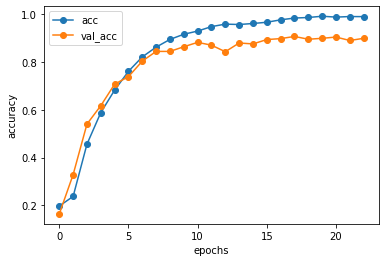

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="o")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

### モデルの保存 & 読み込み

In [11]:
model.save("/Users/tdesu/myhobby/画像認識/五等分の花嫁/models/model.h5")

In [3]:
model = keras.models.load_model("/Users/tdesu/myhobby/画像認識/五等分の花嫁/models/model.h5")

### テストデータへの適応確認

In [12]:
chara_dict = dict(zip(range(6), five_sisters))

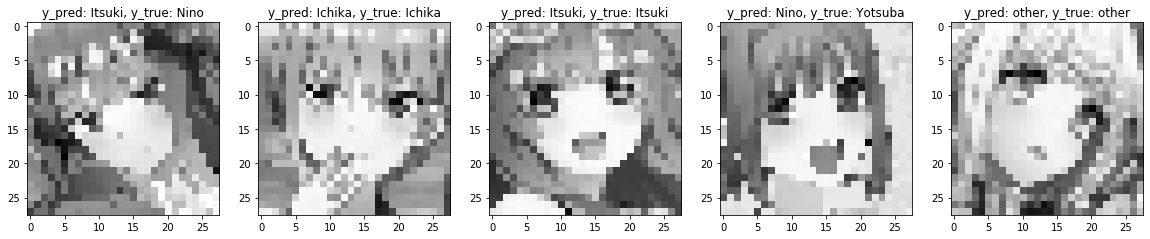

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8))
for i, pred_img in enumerate(X_test[:5]):
    y_pred = model.predict(pred_img.reshape(1,28,28,1))
    ax[i].imshow(pred_img.reshape(28,28), cmap="gray")
    ax[i].set_title(f"y_pred: {chara_dict[y_pred.argmax()]}, y_true: {chara_dict[y_test[i].argmax()]}")

### 未知のデータに適応

In [19]:
#顔検出関数
def detect(image, cascade_path = "/Users/tdesu/myhobby/画像認識/lbpcascade_animeface/lbpcascade_animeface.xml"):
    cascade = cv2.CascadeClassifier(cascade_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #グレースケール変換
    #gray = cv2.equalizeHist(gray)

    faces = cascade.detectMultiScale(gray,
                                     scaleFactor = 1.1,
                                     minNeighbors=1,
                                     minSize = (20, 20)) #minSizeが大きいと複数人認識できない
    
    return faces

#検出された顔を識別する関数
def recognition(image, faces):
    face_images = []
    preds = []
    
    temp_img = image.copy()
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY) #グレースケール変換

    if len(faces) != 0:
        for x, y, w, h in faces:
            face_cut = temp_img[y:y+h, x:x+w]
            face_cut = cv2.resize(face_cut, (28, 28))
            face_cut = face_cut.astype(np.float32)/255.0
            face_images.append(face_cut)
    
    for face_image in face_images:
        face_image = face_image.reshape(1,28,28,1)
        pred = model.predict(face_image)
        preds.append(pred)

    return preds, image

#識別結果を描画する関数
def draw_result(image, faces, result):

    for num, (x, y, w, h) in enumerate(faces):
        classNum = 0
        result_data = result[num]
        classNum = result_data.argmax()
        rate = np.sort(result_data)
        score = rate[-1].max()
        print(classNum)
        recognized_class = five_sisters[classNum]
        color = mem_colors[classNum]
        
        cv2.rectangle(image, (x,y), (x+w, y+h), color, 3)
        cv2.putText(image, five_sisters[classNum], (x,y+h+15), cv2.FONT_HERSHEY_COMPLEX, 0.5, color)
        cv2.putText(image, "%4.1f%%" %(score*100), (x,y+h+30), cv2.FONT_HERSHEY_COMPLEX, 0.5, color)

    return image

#ファイル読み込み
img = cv2.imread("/Users/tdesu/myhobby/画像認識/五等分の花嫁/figures_1/000001.jpg")

faces = detect(img)

result, image = recognition(img, faces)

image = draw_result(image, faces, result)
cv2.imwrite('out.png',image)

3
1
2
0
4
5


True